# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [5]:
# load baselines: filename!!
with open('results/baselines_freeze_True_pool_True_lr_0.001_truncate.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_False_pool_True_truncated.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.000,0.202267
1,0.001,0.001,-1,1,0.875,0.197400
2,0.001,0.001,-1,2,0.875,0.208900
3,0.001,0.001,-1,3,1.000,0.176700
4,0.001,0.001,-1,4,1.000,0.232567


In [6]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.000,0.202267
1,0.001,0.001,-1,1,0.875,0.197400
2,0.001,0.001,-1,2,0.875,0.208900
3,0.001,0.001,-1,3,1.000,0.176700
4,0.001,0.001,-1,4,1.000,0.232567


In [7]:
# optional: if you want to compare two different results, load one by one and rename
df_truncated = df.copy()

In [4]:
df_empirical = df.copy()

In [33]:
# OR LOAD ARI Scores
"""with open("results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()"""

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

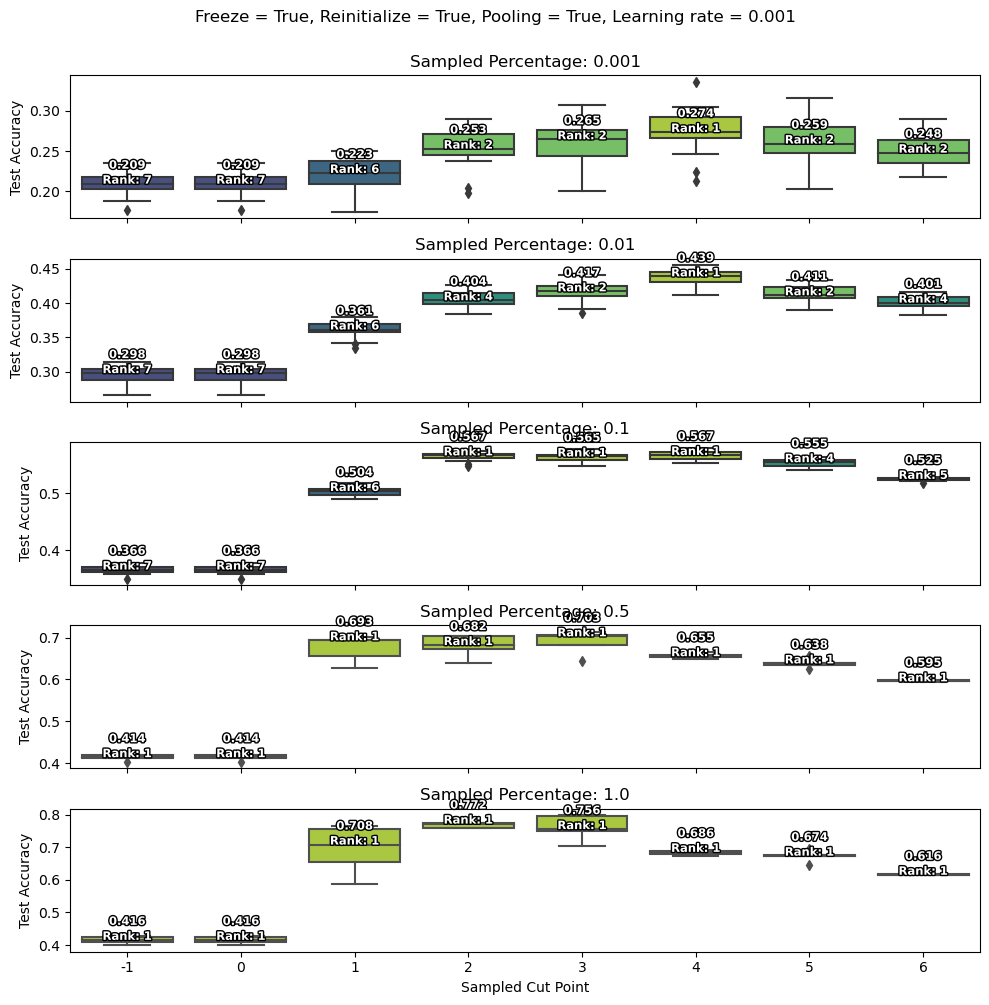

In [97]:
# run statistical tests below to get the df_rankings
df_rankings = pairwise_comparison(df=df)
ranks_sorted = box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params)

In [37]:
# create this dict: rank_color_map = {7: 1, 6:2, 5: 3, 4: 4, 3: 5, 2: 6, 1: 7} that maps ranks in range(1,8) to colors in range(0,7)
# in a for loop in dict comprehension
# the the mapping is reverse
# in dict comprehension

ranks_lim = unique_ranks.max()
rank_color_map = {rank: ranks_lim+1-rank for rank in range(ranks_lim, 0, -1)}


<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

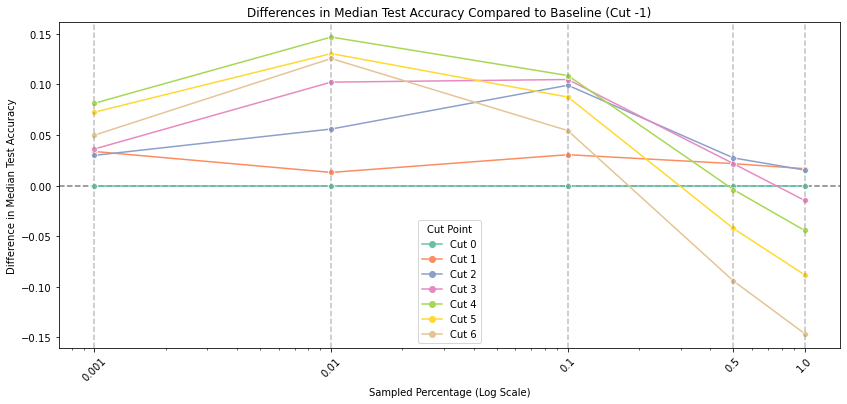

In [9]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

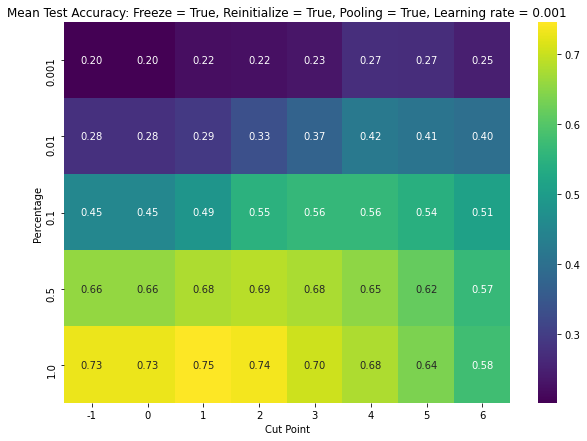

In [10]:
heatmap(df, params, figsize=(10,7))

# 2. Statistical Tests

### Pairwise Comparison between two plots

In [8]:
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_truncated)

In [9]:
stats_empirical = df_empirical.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_empirical = stats_empirical.reset_index()
stats_empirical.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

stats_truncated = df_truncated.groupby(['Percentage', 'Cut Point']).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_truncated = stats_truncated.reset_index()
stats_truncated.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

Two versions:
1. Color the significantly bigger one and significantly smaller one different colors (first cell below)
2. Only 2 colors: one if significant one not

In [10]:
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2

df_rankings_empirical = stats_empirical.copy()
df_rankings_truncated = stats_truncated.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > stats_truncated.iloc[i]['Mean Test Accuracy']:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 1
            df_rankings_truncated.loc[i, 'Mean Test Accuracy'] = 3
        else:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 3
            df_rankings_truncated.loc[i, 'Mean Test Accuracy'] = 1
    else:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 2
        df_rankings_truncated.loc[i, 'Mean Test Accuracy'] = 2

df_rankings_empirical['Mean Test Accuracy'] = df_rankings_empirical['Mean Test Accuracy'].astype(int)
df_rankings_truncated['Mean Test Accuracy'] = df_rankings_truncated['Mean Test Accuracy'].astype(int)

In [79]:
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2

df_rankings_empirical = stats_empirical.copy()
df_rankings_truncated = stats_truncated.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 10
        df_rankings_truncated.loc[i, 'Mean Test Accuracy'] = 10
    else:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 1
        df_rankings_truncated.loc[i, 'Mean Test Accuracy'] = 1

df_rankings_empirical['Mean Test Accuracy'] = df_rankings_empirical['Mean Test Accuracy'].astype(int)
df_rankings_truncated['Mean Test Accuracy'] = df_rankings_truncated['Mean Test Accuracy'].astype(int)

In [81]:
# rename the Mean Test Accuracy column of df_rankings_truncated into rank
df_rankings_truncated.rename(columns={'Mean Test Accuracy': 'rank'}, inplace=True)
df_rankings_empirical.rename(columns={'Mean Test Accuracy': 'rank'}, inplace=True)

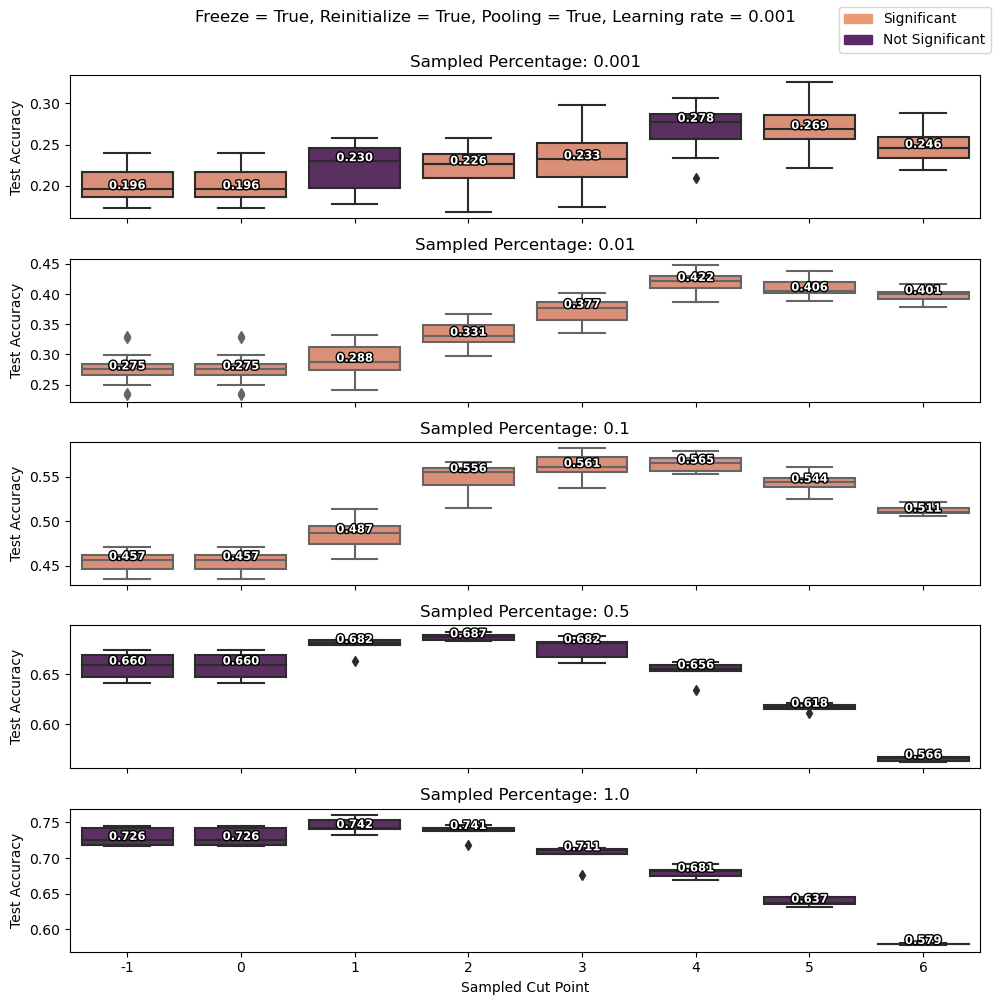

In [94]:
ranks_sorted = box_plot_percentages_experiments(df=df_empirical, rank_df=df_rankings_empirical, pairwise=True, color_palette="flare", add_baseline=False, color_ranks=True, params=params)

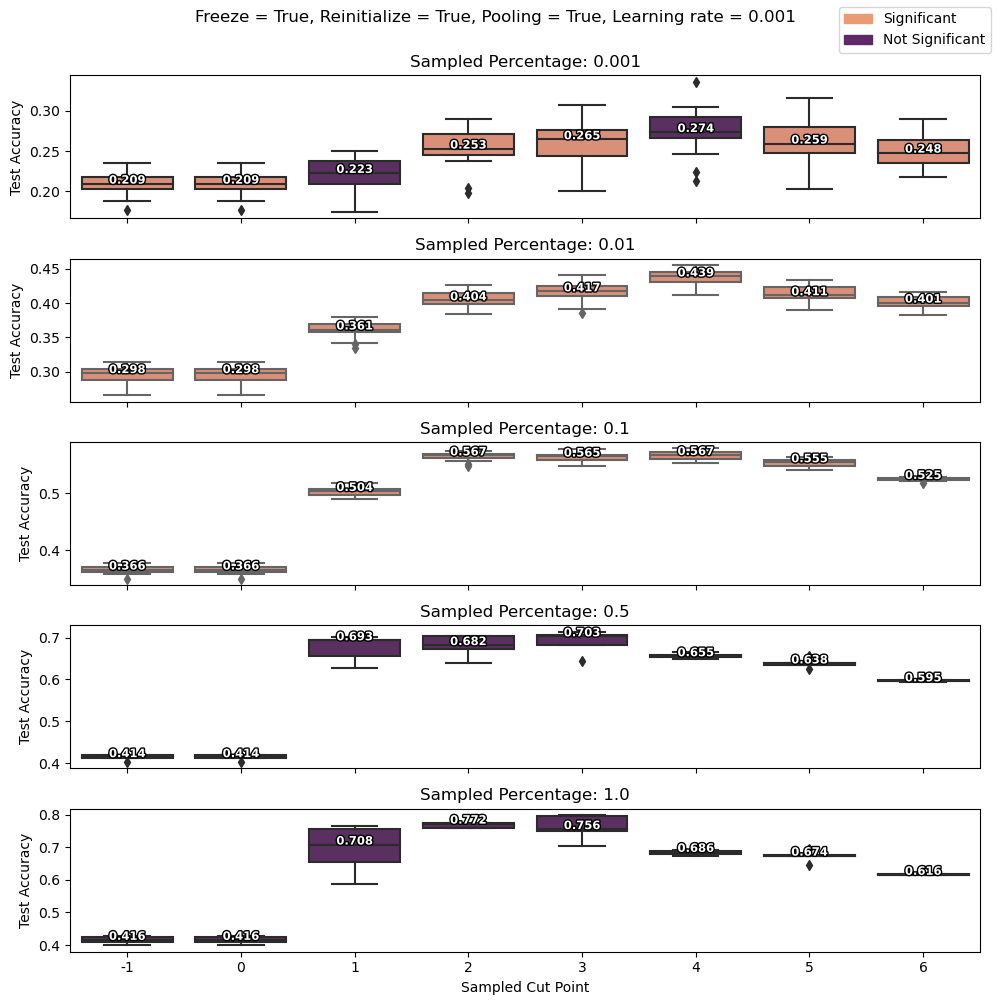

In [96]:
ranks_sorted = box_plot_percentages_experiments(df=df_truncated, rank_df=df_rankings_truncated, pairwise=True, color_palette="flare", color_ranks=True, params=params)